In [1]:
import sys
assert sys.version_info >= (3, 5)

# %tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from time import time
import datetime

%matplotlib inline

SEED = 42
SESSION_NAME = datetime.datetime.now().strftime("%Y%m%d_%H%M")
PI = tf.constant(np.pi)

print(SESSION_NAME)

20191119_0855


Image Data

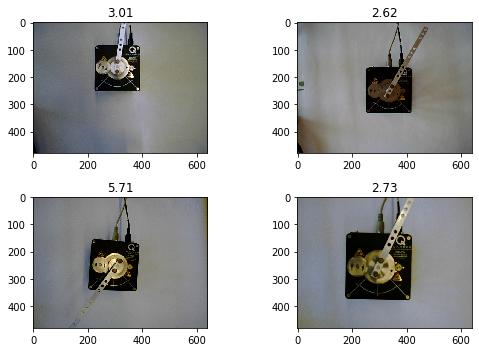

In [2]:
df_train=pd.read_csv("./labels_train.csv",dtype={'id': str, 'label': np.float32})
df_val=pd.read_csv("./labels_val.csv",dtype={'id': str, 'label': np.float32})
df_test=pd.read_csv("./labels_test.csv",dtype={'id': str, 'label': np.float32})
IMG_PATH_TRAIN = "images_train/"
IMG_PATH_VAL = "images_val/"
IMG_PATH_TEST = "images_test/"

df_train.head()

#Visualizing some Examples
fig = plt.figure(figsize=(10,5))
for i in range (1, 5):
    a = fig.add_subplot(2, 2, i)
    imgplot = plt.imshow(mpimg.imread(IMG_PATH_TRAIN+df_train.iloc[(i*10000)-1]['id']), cmap='gray', vmin=0, vmax=1)
    a.set_title(df_train.iloc[(i*10000)-1]['label']) 
    plt.tight_layout()

Data Augmentation Pipeline

Found 80000 validated image filenames.
Found 10000 validated image filenames.
Found 10000 validated image filenames.


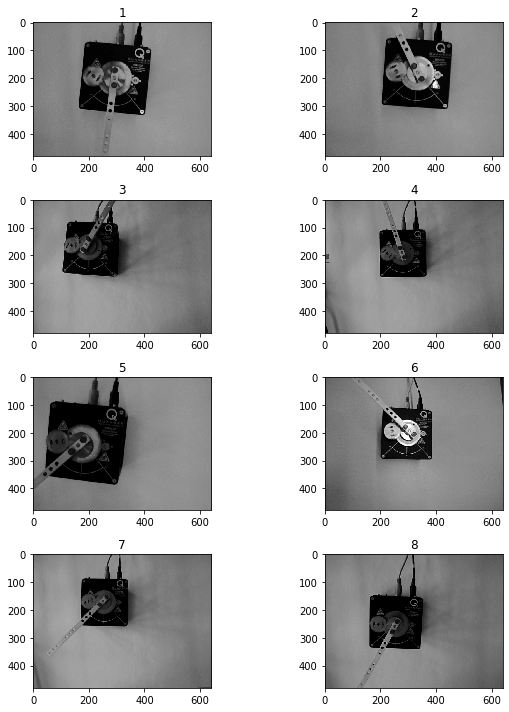

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

HEIGHT = 480
WIDTH = 640
TARGET_HEIGHT = 480
TARGET_WIDTH = 640
CHANNELS = 1
BATCH_SIZE = 16
NUM_TRAIN_IMAGES = 80000
NUM_VAL_IMAGES = 10000
NUM_TEST_IMAGES = 10000

datagen = ImageDataGenerator(rescale = 1/256)

train_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory=IMG_PATH_TRAIN,
                                              x_col="id",
                                              y_col="label",
                                              seed=SEED,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              class_mode="raw",
                                              target_size=(TARGET_HEIGHT,TARGET_WIDTH),
                                              color_mode = "grayscale")

val_generator = datagen.flow_from_dataframe(dataframe=df_val,
                                            directory=IMG_PATH_VAL,
                                            x_col="id",
                                            y_col="label",
                                            seed=SEED,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            class_mode="raw",
                                            target_size=(TARGET_HEIGHT,TARGET_WIDTH),
                                            color_mode = "grayscale")

test_datagen = ImageDataGenerator(rescale = 1/256)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=IMG_PATH_TEST,
                                                  x_col="id",
                                                  y_col="label",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="raw",
                                                  shuffle=False,
                                                  target_size=(TARGET_HEIGHT,TARGET_WIDTH),
                                                  color_mode = "grayscale")

fig = plt.figure(figsize=(12,10))
for X_batch, y_batch in train_generator:
    for i in range(1, 9):
        image = ((X_batch[i-1]*256).astype('uint8'))[:,:,0]
        a = fig.add_subplot(4, 2, i)
        imgplot = plt.imshow(image, cmap='gray', vmin = 0, vmax = 256)
        a.set_title("{}".format(i))
        plt.tight_layout()
    break

Model Definition

In [6]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

model = keras.models.Sequential([
    keras.layers.Conv2D(32, 7, activation="elu", padding="same", kernel_initializer="he_normal", input_shape=[TARGET_HEIGHT,TARGET_WIDTH,CHANNELS]),
    keras.layers.Conv2D(32, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.Conv2D(16, 1, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Conv2D(32, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.Conv2D(16, 1, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Conv2D(32, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.Conv2D(32, 1, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Conv2D(64, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.Conv2D(32, 1, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Conv2D(64, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.Conv2D(64, 1, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Conv2D(128, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.Conv2D(64, 1, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Conv2D(128, 3, activation="elu", padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="elu"),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="elu"),
    keras.layers.Dense(1, activation="relu")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 480, 640, 32)      1600      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 480, 640, 32)      9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 480, 640, 32)      128       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 240, 320, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 240, 320, 16)      528       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 240, 320, 32)      4640      
_________________________________________________________________
batch_normalization_15 (Batc (None, 240, 320, 32)     

Loss and Compilation


In [9]:
def squared_angdiff_and_mse(y_true, y_pred):
    squared_angdiff = tf.square( tf.atan2(tf.sin(y_pred - y_true), tf.cos(y_pred - y_true)) )
    mse = tf.square(y_pred - y_true)
    loss = tf.add(squared_angdiff, mse)
    return loss

def scheduler(epoch):
  if epoch < 3:
    return 0.004
  elif epoch < 6:
    return 0.002
  elif epoch < 20:
    return 0.001
  elif epoch < 30:
    return 0.0008
  else:
    return 0.0005

schedule = keras.callbacks.LearningRateScheduler(scheduler)

FILEPATH_SAVE='checkpoints\{}_model_weights.h5'.format(SESSION_NAME)
checkpoint = keras.callbacks.ModelCheckpoint(FILEPATH_SAVE,
                                             monitor=[squared_angdiff_and_mse],
                                             verbose=1,
                                             mode='min')

FILEPATH_TENSORBOARD_LOG = 'logs\{}'.format(SESSION_NAME)
tensorboard = keras.callbacks.TensorBoard(log_dir = FILEPATH_TENSORBOARD_LOG,
                                          histogram_freq=1,
                                          write_graph=True,
                                          write_images=True,
                                          update_freq=10000,
                                         )

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01,
                                                         beta_1=0.9,
                                                         beta_2=0.95,
                                                         epsilon=1e-07,
                                                         ),
              loss=squared_angdiff_and_mse,
              metrics=[squared_angdiff_and_mse, 'mae'])

Training


In [10]:
# Training constants
NUM_EPOCHS = 20

history = model.fit_generator(generator=train_generator, 
                              validation_data=val_generator,
                              validation_steps=625,
                              steps_per_epoch=5000,
                              epochs=NUM_EPOCHS,
                              callbacks=[tensorboard, checkpoint, schedule])

Epoch 1/20
4999/5000 [============================>.] - ETA: 0s - loss: 1.2390 - squared_angdiff_and_mse: 1.2390 - mae: 0.4495
Epoch 00001: saving model to checkpoints\20191119_0855_model_weights.h5
5000/5000 [==============================] - 1986s 397ms/step - loss: 1.2387 - squared_angdiff_and_mse: 1.2387 - mae: 0.4494 - val_loss: 1.4114 - val_squared_angdiff_and_mse: 1.4114 - val_mae: 0.4850
Epoch 2/20
4999/5000 [============================>.] - ETA: 0s - loss: 0.2928 - squared_angdiff_and_mse: 0.2928 - mae: 0.1868
Epoch 00002: saving model to checkpoints\20191119_0855_model_weights.h5
5000/5000 [==============================] - 1783s 357ms/step - loss: 0.2927 - squared_angdiff_and_mse: 0.2927 - mae: 0.1868 - val_loss: 1.4900 - val_squared_angdiff_and_mse: 1.4900 - val_mae: 0.5651
Epoch 3/20
4999/5000 [============================>.] - ETA: 0s - loss: 0.2128 - squared_angdiff_and_mse: 0.2128 - mae: 0.1563
Epoch 00003: saving model to checkpoints\20191119_0855_model_weights.h5
500

Evaluation

In [7]:
model.evaluate_generator(generator=test_generator, steps= 625)

[0.21639828685447574, 0.21639824, 0.14449598]

Testing Results

In [8]:
test_generator.reset()
pred=model.predict_generator(test_generator, verbose=1)
filenames=test_generator.filenames
labels = []
for filename in filenames:
    labels.append('.'.join([filename.split('_')[1].split('.')[0], filename.split('_')[1].split('.')[1]]))
labels_f = [float(x) for x in labels]
pred_f = [float(x) for x in pred]
diff = []
for i in range(len(labels)):
    diff.append(pred_f[i]-labels_f[i]) 
results=pd.DataFrame({"Filename":filenames,
                      "Label": labels,
                      "Predictions":pred.tolist(),
                      "Difference": diff})
results.to_csv("results_train_{}.csv".format(SESSION_NAME),index=False)
results.head()

625/625 [==============================] - 89s 142ms/step


,Filename,Label,Predictions,Difference
0,1573560928.626884_0.05.png,0.05,[0.0],-0.050000
1,1573560928.8591487_0.15.png,0.15,[0.0],-0.150000
2,1573560929.0794158_0.22.png,0.22,[0.0],-0.220000
3,1573560929.3035173_0.3.png,0.3,[0.393441379070282],0.093441
4,1573560929.5403802_0.37.png,0.37,[0.4477759599685669],0.077776


In [9]:
model.save("17_11\model_{}.h5".format(SESSION_NAME))
model.save("17_11\model_{}".format(SESSION_NAME))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 17_11\model_20191117_1315\assets


In [10]:
model.save_weights("17_11\model_weights_{}".format(SESSION_NAME))

In [12]:
%tensorboard --logdir logs\20191117_1315

Reusing TensorBoard on port 6006 (pid 540), started 0:00:48 ago. (Use '!kill 540' to kill it.)

# Erwartung

das Modell underfittet durch die viel geringere Anzahl an Parameter

# Ergebniss
---
